# EXPLORATION
# 6. 카메라 스티커앱 만들기 첫걸음[프로젝트]

In [1]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/aiffel_project/data/camera_sticker

Mounted at /content/drive
/content/drive/MyDrive/aiffel/aiffel_project/data/camera_sticker


## 6-1. 프로젝트: 고양이 수염 스티커 만들기

In [2]:
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.7.0
19.24.1


### step1. 스티커 구하기 or 만들기

고양이 수염 이미지 확인

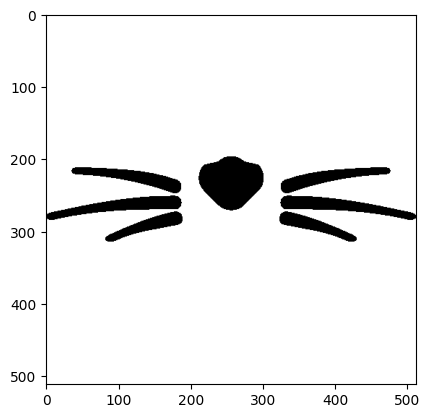

In [3]:
import matplotlib.pyplot as plt

def show_img(path):

    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    return img_rgb

cat_rgb = show_img('images/cat.png')

셀카 이미지 확인

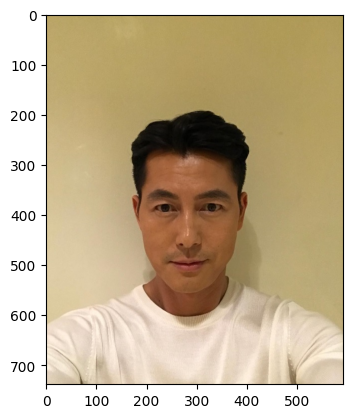

In [4]:
img_rgb = show_img('images/jeong.jpg')

### step2. 얼굴 검출 & 랜드마크 검출하기

rectangles[[(167, 316) (390, 539)]]
68


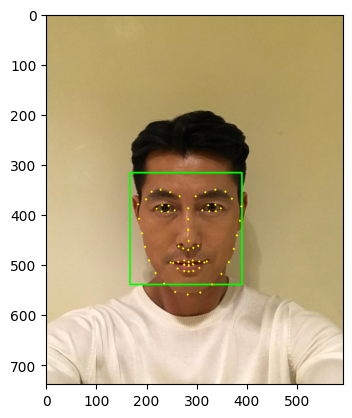

In [5]:
def face_detection(img):
    try:
        img_show = img.copy()
        detector_hog = dlib.get_frontal_face_detector()
        dlib_rects = detector_hog(img_show, 1)
        print(dlib_rects)


        for dlib_rect in dlib_rects:
            l = dlib_rect.left()
            t = dlib_rect.top()
            r = dlib_rect.right()
            b = dlib_rect.bottom()

            cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

        model_path = 'models/shape_predictor_68_face_landmarks.dat'

        landmark_predictor = dlib.shape_predictor(model_path)

        list_landmarks = []

        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_show, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        print(len(list_landmarks[0]))

        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img_show, point, 2, (255, 255, 0), -1)

            plt.imshow(img_show)

        return dlib_rects, list_landmarks

    except:
        raise IndexError("Face detection failed...")

dlib_rects, list_landmarks = face_detection(img_rgb)

### Step3. 스티커 적용 위치 확인하기

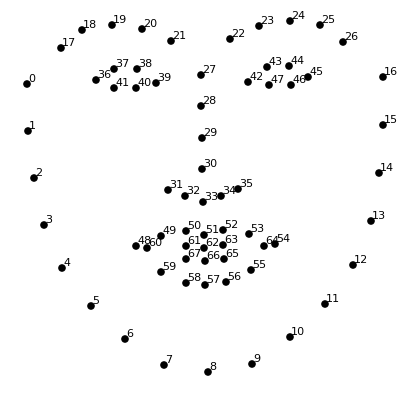

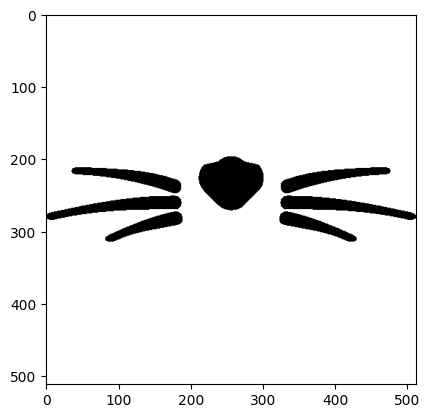

고양이 수염 이미지의 정중앙이 코 아랫부분입니다.  
따라서 고양이 수염 이미지의 중앙을 랜드마크 30번과 33번 사이에 맞추면 될 것 같습니다.

### Step4. 스티커 적용하기

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0] - ((landmark[33][0] - landmark[30][0])//2)
    y = landmark[33][1] - ((landmark[33][1] - landmark[30][1])//2)
    w = h = dlib_rect.width()
    print(f'nose center(x, y): ({x}, {y})')
    print(f'rectangle size(w, h): ({w}, {h})')

nose center(x, y): (284, 461)
rectangle size(w, h): (224, 224)


In [7]:
print(f'image size: {img_rgb.shape}')
print(f'cat size: {cat_rgb.shape}')

image size: (738, 592, 3)
cat size: (512, 512, 3)


수염 이미지가 굉장히 큽니다.  
수염 이미지를 얼굴 인식에 사용한 사각형 크기와 동일하게 줄여줍니다.

In [8]:
cat_resize = cv2.resize(cat_rgb, (w, h))

cat_resize.shape

(224, 224, 3)

적당한 크기로 줄어들었습니다.

- 수염 이미지의 중앙 = (수염 가로//2, 수염 세로//2)
- 원본 이미지의 33번 랜드마크 = landmark[33]
- 스티커 영역의 가로 = [ (x - 수염 가로//2) : (x - 수염 가로//2) + 수염 가로 ]
- 스티커 영역의 세로 = [ (y - 수염 세로//2) : (y - 수염 세로//2) + 수염 세로 ]


(1) np.where 사용해서 스티커 적용하기

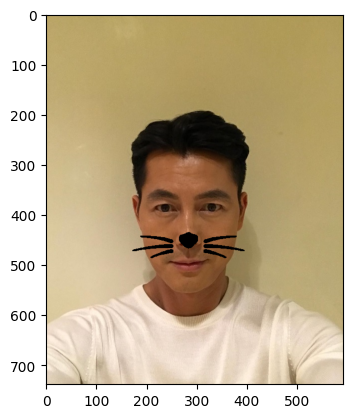

In [9]:
import numpy as np

def apply_sticker(img, sticker, x, y):
    img_show = img.copy()
    refined_x = x - sticker.shape[1]//2
    refined_y = y - sticker.shape[0]//2

    # 이미지보다 스티커가 왼쪽으로 튀어나온 경우
    if refined_x < 0:
        sticker = sticker[:, -refined_x:]
        refined_x = 0
    
    # 이미지보다 스티커가 오른쪽으로 튀어나온 경우
    if refined_x + sticker.shape[1] > img_show.shape[1]:
        sticker = sticker[:, :img_show.shape[1] - refined_x]

    sticker_area = img_show[refined_y:refined_y + sticker.shape[0],
                            refined_x:refined_x + sticker.shape[1]]

    img_show[refined_y:refined_y + sticker.shape[0],
            refined_x:refined_x + sticker.shape[1]] = \
        np.where(sticker==0, sticker, sticker_area).astype(np.uint8)

    return img_show

result_img = apply_sticker(img_rgb, cat_resize, x, y)
plt.imshow(result_img)

(2) opencv의 cv2.addWeighted()를 참고하여 스티커 뒤로 원본 이미지가 같이 보이도록 만들기

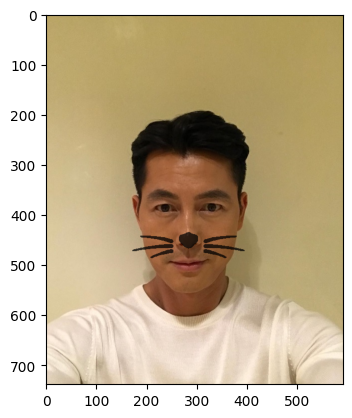

In [10]:
def transparent_sticker(img, sticker, x, y, a):
    img_show = img.copy()
    refined_x = x - sticker.shape[1]//2
    refined_y = y - sticker.shape[0]//2

    # 이미지보다 스티커가 왼쪽으로 튀어나온 경우
    if refined_x < 0:
        sticker = sticker[:, -refined_x:]
        refined_x = 0
    
    # 이미지보다 스티커가 오른쪽으로 튀어나온 경우
    if refined_x + sticker.shape[1] > img_show.shape[1]:
        sticker = sticker[:, :img_show.shape[1] - refined_x]

    sticker_area = img_show[refined_y:refined_y + sticker.shape[0],
                            refined_x:refined_x + sticker.shape[1]]

    img_show[refined_y:refined_y + sticker.shape[0],
            refined_x:refined_x + sticker.shape[1]] = \
        cv2.addWeighted(sticker_area, 1 - a, 
                    np.where(sticker==0, sticker, sticker_area).astype(np.uint8),
                    a, 0)

    return img_show

result_img = transparent_sticker(img_rgb, cat_resize, x, y, 0.75)
plt.imshow(result_img)

##추가적인 테스트

### 얼굴이 옆으로 기울여 촬영된 사진에도 적용하려면?

스티커 이미지를 이미지의 얼굴 기울기와 일치하게 회전시키면 될 것 같습니다.

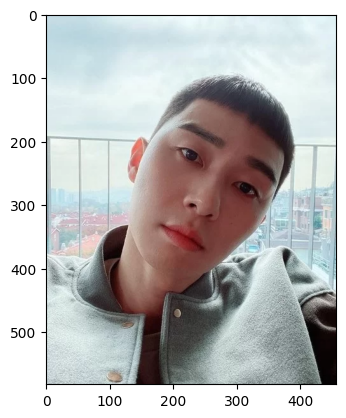

In [11]:
img_rgb = show_img('images/park.png')

rectangles[[(117, 192) (340, 415)]]
68


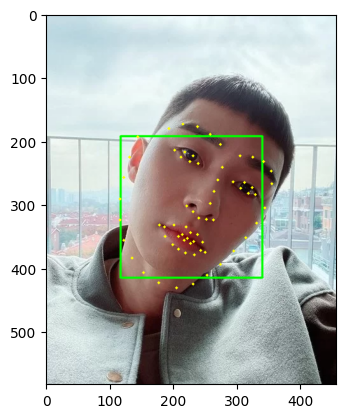

In [12]:
dlib_rects, list_landmarks = face_detection(img_rgb)

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0] - ((landmark[33][0] - landmark[30][0])//2)
    y = landmark[33][1] - ((landmark[33][1] - landmark[30][1])//2)
    w = h = dlib_rect.width()
    print(f'nose center(x, y): ({x}, {y})')
    print(f'rectangle size(w, h): ({w}, {h})')

nose center(x, y): (249, 310)
rectangle size(w, h): (224, 224)


In [14]:
cat_resize = cv2.resize(cat_rgb, (w, h))

cat_resize.shape

(224, 224, 3)

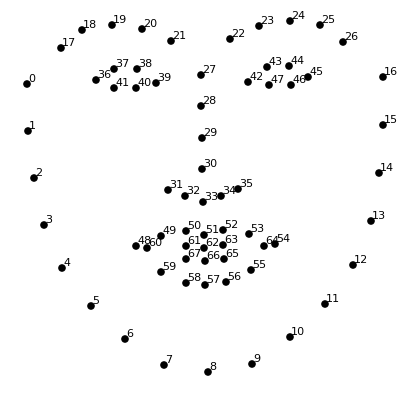

이제 촬영한 사진이 얼마나 기울어져 있는지 확인합니다.  
**코의 시작점인 27번**과 **인중과 코가 만나는 지점인 33번**의 **기울기**를 확인한다면 이미지에서 얼굴의 기울기를 확인할 수 있을 것 같습니다.

In [15]:
landmark[27]

(277, 241)

In [16]:
landmark[33]

(240, 321)

얼마나 기울어져 있는지는 다음과 같은 순서로 확인합니다.

1. 두 점의 좌표를 이용하여 y축으로부터의 기울기를 구합니다(dx / dy)
2. 아크탄젠트 함수와 기울기를 이용하여 각도(라디안)을 구합니다.
3. 라디안을 육십분법으로 변환합니다.

In [17]:
gradient = ((landmark[27][0] - landmark[33][0]) / (landmark[27][1] - landmark[33][1])
                                                  + 1e-10)  # division by zero 방지
angle_rad = np.arctan(gradient)
angle_deg = np.degrees(angle_rad)

In [18]:
angle_deg

-24.820541330769128

-25도 정도가 나오는 것을 확인할 수 있습니다.  
반시계 방향으로 -25도(시계 방향으로 25도) 회전했다는 의미입니다.

(우상향 직선은 일반적인 좌표축에선 y와 x가 모두 증가하는 모양새로 양의 기울기를 갖게 되지만, 이미지 좌표는 좌상단이 (0, 0)인 모양이기 때문에 y가 감소할 때 x가 증가함으로 음의 기울기를 갖게 됩니다.)

nose center(x, y): (249, 310)
rectangle size(w, h): (224, 224)


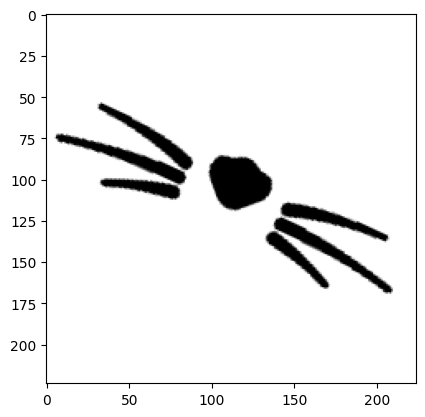

In [19]:
def rotated_sticker(dlib_rects, list_landmarks, sticker):
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[33][0] - ((landmark[33][0] - landmark[30][0])//2)
        y = landmark[33][1] - ((landmark[33][1] - landmark[30][1])//2)
        w = h = dlib_rect.width()
    print(f'nose center(x, y): ({x}, {y})')
    print(f'rectangle size(w, h): ({w}, {h})')

    sticker_resize = sticker.copy()
    sticker_resize = cv2.resize(sticker_resize, (w, h))

    gradient = ((landmark[27][0] - landmark[33][0]) / (landmark[27][1] - landmark[33][1])
                                                  + 1e-10)  # division by zero 방지
    angle_rad = np.arctan(gradient)
    angle_deg = np.degrees(angle_rad)
    
    transform_matrix = cv2.getRotationMatrix2D((sticker_resize.shape[1]//2,
                                                sticker_resize.shape[0]//2),
                                                angle_deg, 1)
    result = cv2.warpAffine(sticker_resize, transform_matrix,
                (sticker_resize.shape[0], sticker_resize.shape[1]), 
                borderValue=(255, 255, 255))
    plt.imshow(result)
    
    return result, x,  y

cat_resize, x, y = rotated_sticker(dlib_rects, list_landmarks, cat_rgb)

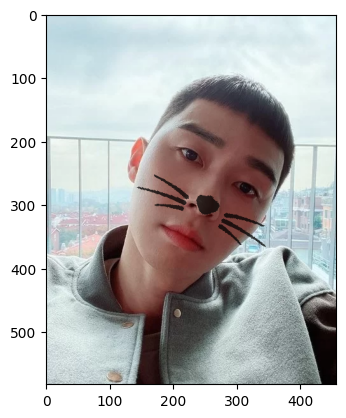

In [20]:
result_img = transparent_sticker(img_rgb, cat_resize, x, y, 0.75)
plt.imshow(result_img)

### 사람이 여러명일 경우?

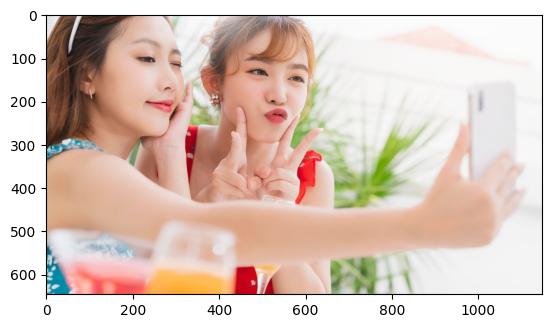

In [21]:
img_rgb = show_img('images/2people.jpg')

기존의 face_detection함수의 dlib_rects는 감지된 얼굴의 모든 사각형 영역을, list_landmarks는 감지된 얼굴의 모든 랜드마크들을 return합니다.

그러므로 face_detection함수는 수정할 필요가 없습니다.

rectangles[[(414, 68) (637, 291)], [(142, 43) (365, 266)]]
68


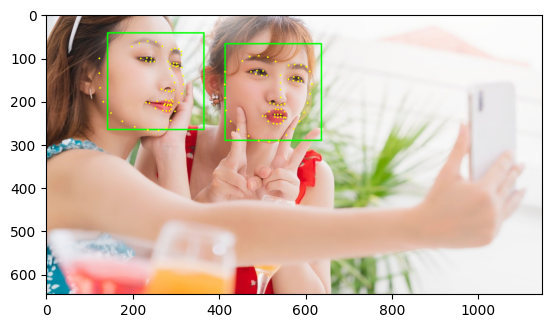

In [22]:
dlib_rects, list_landmarks = face_detection(img_rgb)

nose center(x, y): (540, 201)
rectangle size(w, h): (224, 224)
nose center(x, y): (291, 168)
rectangle size(w, h): (224, 224)


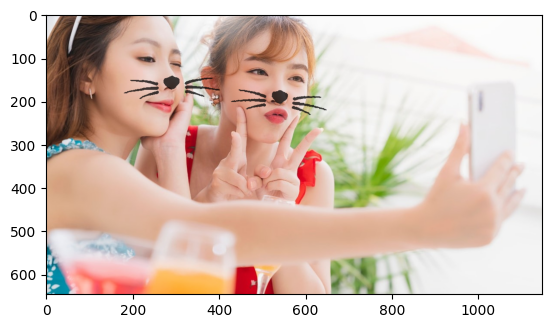

In [23]:
def multiple_rotated_sticker(dlib_rects, list_landmarks, sticker, img):
    x = list_landmarks[0][33][0] - ((list_landmarks[0][33][0] - list_landmarks[0][30][0])//2)
    y = list_landmarks[0][33][1] - ((list_landmarks[0][33][1] - list_landmarks[0][30][1])//2)
    w = h = dlib_rects[0].width()
    print(f'nose center(x, y): ({x}, {y})')
    print(f'rectangle size(w, h): ({w}, {h})')

    sticker_resize = sticker.copy()
    sticker_resize = cv2.resize(sticker_resize, (w, h))

    gradient = ((list_landmarks[0][27][0] - list_landmarks[0][33][0]) / 
                (list_landmarks[0][27][1] - list_landmarks[0][33][1])
                                                + 1e-10)  # division by zero 방지
    angle_rad = np.arctan(gradient)
    angle_deg = np.degrees(angle_rad)
    
    transform_matrix = cv2.getRotationMatrix2D((sticker_resize.shape[1]//2,
                                                sticker_resize.shape[0]//2),
                                                angle_deg, 1)
    sticker_resize = cv2.warpAffine(sticker_resize, transform_matrix,
                (sticker_resize.shape[0], sticker_resize.shape[1]), 
                borderValue=(255, 255, 255))
    
    result_img = transparent_sticker(img, sticker_resize, x, y, 0.75)

    # 재귀함수를 사용합니다.
    if len(list_landmarks) > 1:
        result_img = multiple_rotated_sticker(dlib_rects[1:], list_landmarks[1:], sticker, result_img)
    return result_img

result_img = multiple_rotated_sticker(dlib_rects, list_landmarks, cat_rgb, img_rgb)
plt.imshow(result_img)

### 어두워서 얼굴이 인식되지 않을땐?

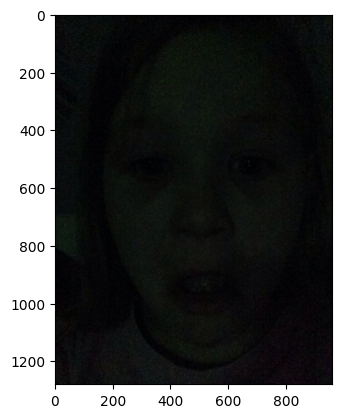

In [24]:
img_rgb = show_img('images/dark.jpg')

In [25]:
dlib_rects, list_landmarks = face_detection(img_rgb)

rectangles[]


IndexError: ignored

사진이 너무 어두워서 얼굴 인식에 실패했습니다.

RGB 이미지를 YCbCr 이미지로 변경하여 Y(밝기) 채널의 이미지를 살펴보겠습니다.

In [26]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

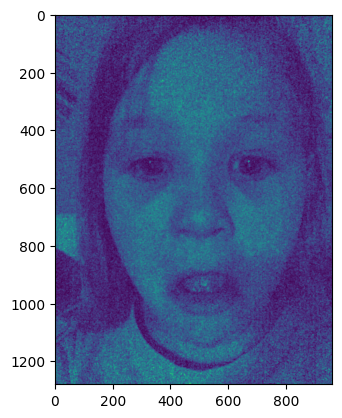

In [27]:
plt.imshow(img_ycbcr[:, :, 0])

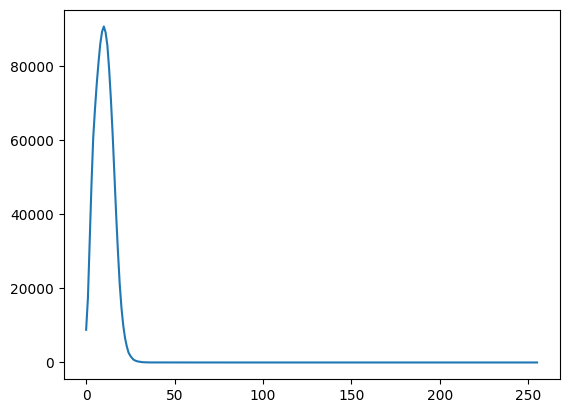

In [28]:
hist = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])  # 이미지, 채널, 마스크 여부, BIN개수, 픽셀값 범위
plt.plot(hist)

이미지의 밝기가 전체적으로 낮은 것을 확인할 수 있습니다.

히스토그램 평활화를 진행하여 히스토그램의 분포를 넓게 바꿔줍니다.

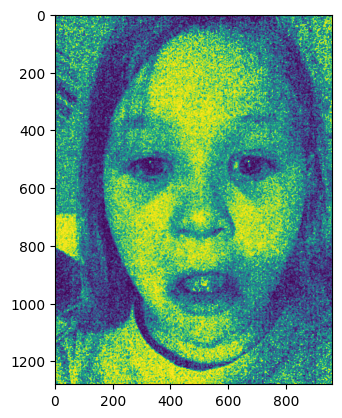

In [29]:
brightness_img = img_ycbcr[:, :, 0]
equalized_img = cv2.equalizeHist(brightness_img)
plt.imshow(equalized_img)

이미지의 밝기가 전체적으로 개선된 것이 보입니다.

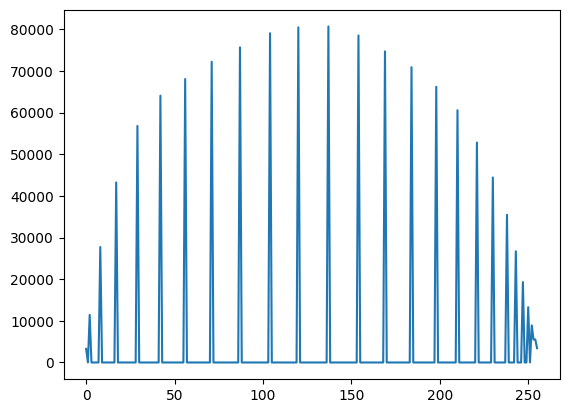

In [30]:
equalized_hist = cv2.calcHist([equalized_img], [0], None, [256], [0, 256])
plt.plot(equalized_hist)

평활화가 진행된 히스토그램은 위와 같은 형태로 변하게 됩니다.

밝기값이 개선된 Y채널을 포함한 YCbCr 이미지를 다시 RGB 이미지로 바꿉니다.

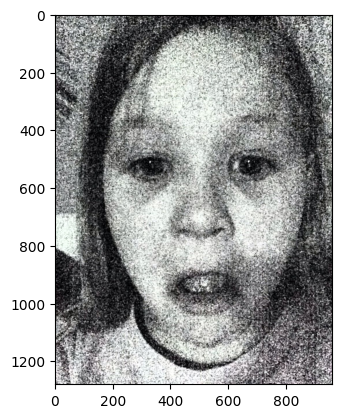

In [31]:
img_ycbcr[:, :, 0] = equalized_img
equalized_img_bgr = cv2.cvtColor(img_ycbcr, cv2.COLOR_YCrCb2BGR)
equalized_img_rgb = cv2.cvtColor(equalized_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(equalized_img_rgb)

rectangles[[(70, 337) (869, 1136)]]
68


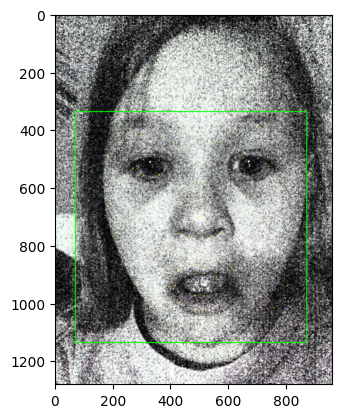

In [32]:
dlib_rects, list_landmarks = face_detection(equalized_img_rgb)

얼굴인식이 잘 되는 것을 확인할 수 있습니다.

나머지는 앞서 진행했던 것처럼 원본 이미지에 스티커를 붙여줍니다.

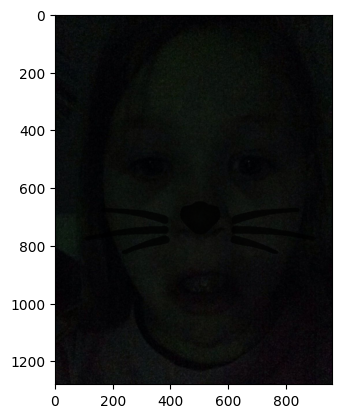

In [33]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0] - ((landmark[33][0] - landmark[30][0])//2)
    y = landmark[33][1] - ((landmark[33][1] - landmark[30][1])//2)
    w = h = dlib_rect.width()

cat_resize = cv2.resize(cat_rgb, (w, h))

result_img = transparent_sticker(img_rgb, cat_resize, x, y, 0.75)
plt.imshow(result_img)

### 어두운 단체사진은?

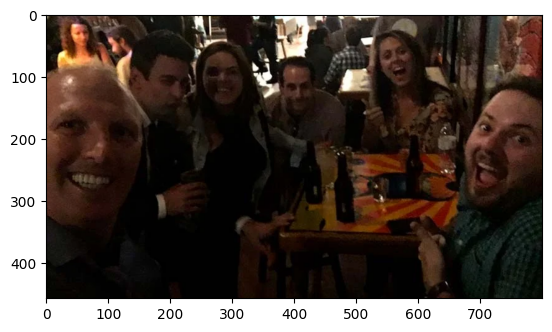

In [34]:
img_rgb = show_img('images/dark_group.png')

rectangles[[(536, 46) (598, 108)], [(245, 72) (320, 146)], [(655, 153) (784, 282)], [(165, 76) (255, 166)], [(377, 101) (439, 163)]]
68


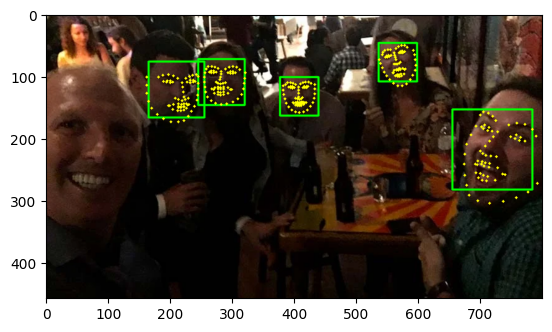

In [35]:
dlib_rects, list_landmarks = face_detection(img_rgb)

멀리 있는 사람은 작아서 인식에 실패한 것 같습니다.

하지만 좌측 하단의 사람은 왜 인식에 실패했을까요?  
아마 밝기의 문제같으니 히스토그램 평활화를 이용해 밝기를 조정 해보겠습니다.

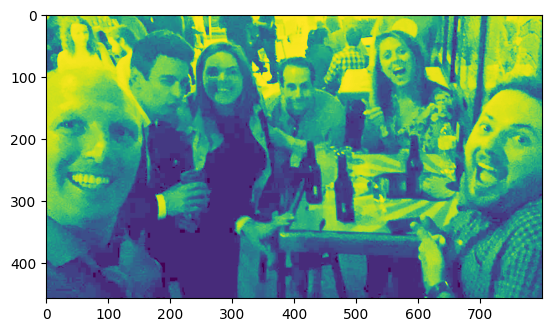

In [36]:
def make_bright_image(img):
    temp = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_ycbcr = cv2.cvtColor(temp, cv2.COLOR_BGR2YCrCb)
    brightness_img = img_ycbcr[:, :, 0]
    equalized_img = cv2.equalizeHist(brightness_img)
    plt.imshow(equalized_img)

    img_ycbcr[:, :, 0] = equalized_img
    equalized_img_bgr = cv2.cvtColor(img_ycbcr, cv2.COLOR_YCrCb2BGR)
    equalized_img_rgb = cv2.cvtColor(equalized_img_bgr, cv2.COLOR_BGR2RGB)

    return equalized_img_rgb

equalized_img_rgb = make_bright_image(img_rgb)

rectangles[[(536, 46) (598, 108)], [(245, 72) (320, 146)], [(165, 76) (255, 166)], [(655, 153) (784, 282)], [(377, 101) (439, 163)], [(-56, 93) (191, 316)]]
68


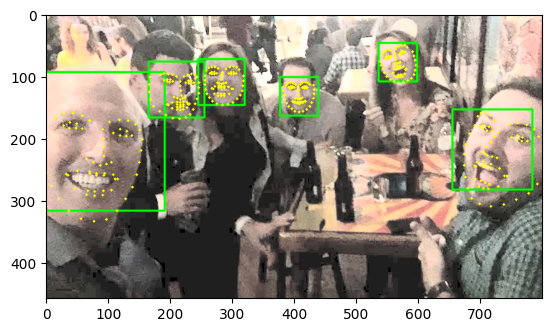

In [37]:
dlib_rects, list_landmarks = face_detection(equalized_img_rgb)

앞사람의 얼굴까지 잘 인식되는 것을 확인할 수 있습니다.

nose center(x, y): (565, 76)
rectangle size(w, h): (63, 63)
nose center(x, y): (283, 109)
rectangle size(w, h): (76, 76)
nose center(x, y): (217, 134)
rectangle size(w, h): (91, 91)
nose center(x, y): (711, 220)
rectangle size(w, h): (130, 130)
nose center(x, y): (408, 136)
rectangle size(w, h): (63, 63)
nose center(x, y): (90, 236)
rectangle size(w, h): (248, 248)


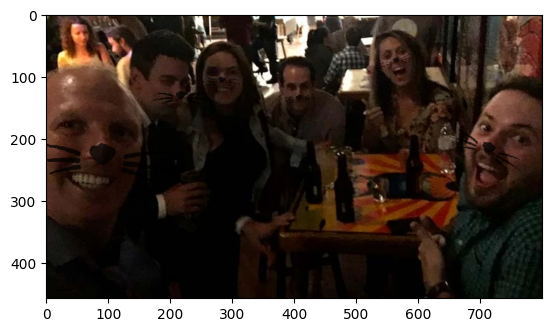

In [38]:
result_img = multiple_rotated_sticker(dlib_rects, list_landmarks, cat_rgb, img_rgb)
plt.imshow(result_img)

### 역광이라면?

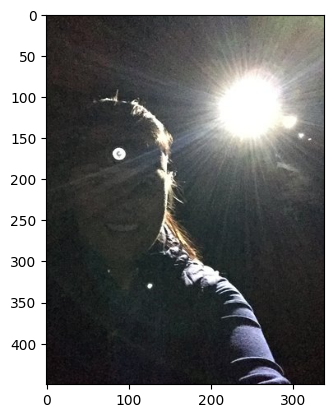

In [39]:
img_rgb = show_img('images/dark-selfie.jpg')

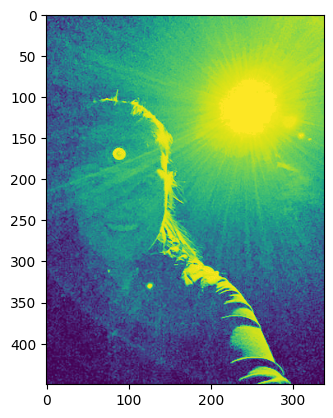

In [40]:
equalized_img_rgb = make_bright_image(img_rgb)

In [41]:
dlib_rects, list_landmarks = face_detection(equalized_img_rgb)

rectangles[]


IndexError: ignored

뭔가 다른 해결책이 필요할 것 같습니다...

## 결론
- 얼굴 각도에 따라 스티커를 적용하기 위해선 얼굴이 얼마나 기울어졌는지 각도를 구해 해결
- 이미지 밝기에 따라 얼굴이 인식되지 않는 문제는 부분적으로 YCbCr형태로 변환하여 Y채널에 저장된 밝기값을 히스토그램 평활화하여 해결

촬영 거리가 멀어지거나 옆으로 누워서 촬영하면 얼굴을 인식하지 못하는 이유는 다음과 같이 추측했습니다.
- HOG가 이미지를 여러 작은 구역들로 나누어 해당 구역에서 중심 픽셀이 주변 픽셀들과 비교하여 어느 방향으로 밝기가 변하는지, 얼마나 값이 차이가 나는지 gradient의 방향과 크기를 나타내는 벡터를 이용하여 학습을 한 것으로 생각되어 얼굴이 너무 작거나 옆으로 완전 누워있는 경우는 인식을 하지 못하는 것 같습니다.

스티커 앱의 실행 속도와 정확도에 대한 의견은
- 실행 속도는 매우 중요할 것 같습니다. 프로젝트에서 다룬 대상은 한 장의 영상이지만, 동영상처럼 여러 프레임을 다루는 문제가 된다면 실행 속도가 중요하게 될 것입니다.
- 정확도는 어려운 문제이긴 한데 앞서 제시된 문제점들인 너무 얼굴이 작게 찍히거나 누워있거나 등의 문제도 있고 실행 속도의 관점에서 볼 때 모든 프레임을 정확하게 처리하려고 하면 오히려 실행 속도가 오래 걸릴 것 같습니다.